In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load data
file_2022 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-22_12-00_AM_1_Year_1732084536_v2.xlsx')
file_2023 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-23_12-00_AM_1_Year_1732084578_v2.xlsx')
file_2024 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-24_12-00_AM_1_Year_1732084607_v2.xlsx')

# Prepare the data
cols_needed = ['Date & Time', 'Rain - mm', 'Rain Rate - mm/h']
df_2022 = file_2022[cols_needed]
df_2023 = file_2023[cols_needed]
df_2024 = file_2024[cols_needed]
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)


In [3]:
# Clean and resample data
combined_df['Date & Time'] = pd.to_datetime(combined_df['Date & Time'], format='%m/%d/%y %I:%M %p')
combined_df = combined_df.sort_values(by='Date & Time')
combined_df['Rain - mm'] = combined_df['Rain - mm'].fillna(0)
combined_df['Rain Rate - mm/h'] = combined_df['Rain Rate - mm/h'].fillna(0)

resampled_15min = combined_df.set_index('Date & Time').resample('15min').mean()
resampled_1hr = combined_df.set_index('Date & Time').resample('1h').mean()
resampled_15min.ffill(inplace=True)
resampled_1hr.ffill(inplace=True)

for df in [resampled_15min, resampled_1hr]:
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

In [4]:
# Normalize the data
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

def normalize_data(data):
    normalized_data = data.copy()
    features = ['Rain - mm', 'Rain Rate - mm/h', 'hour', 'day_of_week']
    normalized_data[features] = scaler_features.fit_transform(data[features])
    normalized_data['Rain Rate - mm/h'] = scaler_labels.fit_transform(data[['Rain Rate - mm/h']])
    return normalized_data

normalized_15min = normalize_data(resampled_15min)
normalized_1hr = normalize_data(resampled_1hr)

joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_labels, 'scaler_labels.pkl')

['scaler_labels.pkl']

In [5]:
# Create LSTM sequences
def create_lstm_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length, :].values
        label = data.iloc[i + sequence_length]['Rain Rate - mm/h']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 30
X_15min, y_15min = create_lstm_sequences(normalized_15min, sequence_length)
X_1hr, y_1hr = create_lstm_sequences(normalized_1hr, sequence_length)


In [6]:
# Build LSTM model with improvements
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

Epoch 1/50


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


538/538 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.4929 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0529 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0591 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1257 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1515 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0483 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0454 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0877 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 9/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.2106 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.4970 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 2/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0503 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 3/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0295 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 4/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0475 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 5/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0604 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 6/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1449 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 7/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0783 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 8/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1489 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 9/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0793 - val_loss: 0.0283 - learnin

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2663 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.1322 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0345 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0403 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0348 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0300 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 7/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0333 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 8/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0612 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 9/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0356 - val_loss: 0.0432 - learnin

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.2941 - val_loss: 1.1475 - learning_rate: 0.0010
Epoch 2/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0355 - val_loss: 0.8387 - learning_rate: 0.0010
Epoch 3/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0294 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 4/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0310 - val_loss: 0.7209 - learning_rate: 0.0010
Epoch 5/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0402 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 6/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0601 - val_loss: 0.4803 - learning_rate: 0.0010
Epoch 7/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0387 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 8/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0535 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 9/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0356 - val_loss: 2.4745 - learnin

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.2497 - val_loss: 3.1301 - learning_rate: 0.0010
Epoch 2/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.1125 - val_loss: 3.0677 - learning_rate: 0.0010
Epoch 3/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.1166 - val_loss: 3.1043 - learning_rate: 0.0010
Epoch 4/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.1534 - val_loss: 3.0295 - learning_rate: 0.0010
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1086 - val_loss: 3.0681 - learning_rate: 0.0010
Epoch 6/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.1085 - val_loss: 2.9660 - learning_rate: 0.0010
Epoch 7/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.2014 - val_loss: 3.0501 - learning_rate: 0.0010
Epoch 8/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.2103 - val_loss: 2.8639 - learning_rate: 0.0010
Epoch 9/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.2079 - val_loss: 2.9347 - learnin

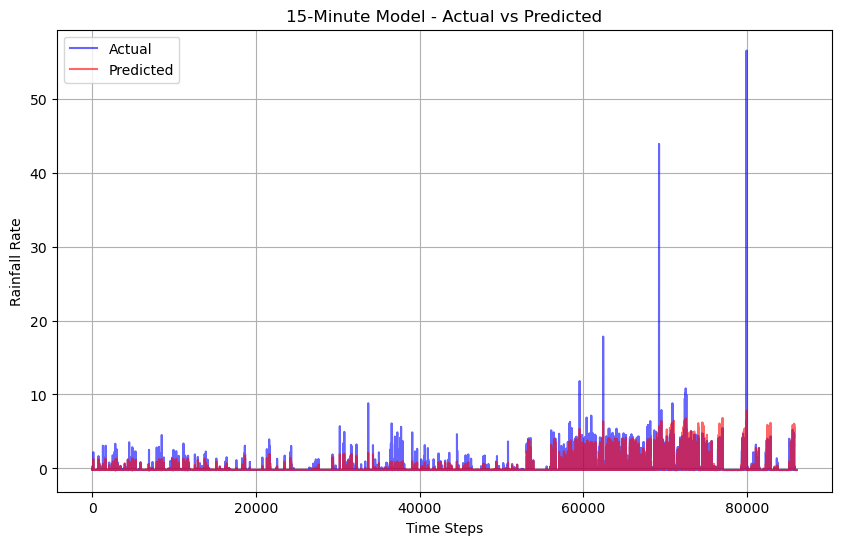

Epoch 1/50


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7606 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3265 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2298 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1614 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0728 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0504 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1010 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0514 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0691 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 10/50


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6587 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1920 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1204 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0568 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0214 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0368 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0147 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0579 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 9/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0721 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 10/50


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.3379 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0579 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0300 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0498 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0159 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0255 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0136 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0263 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 9/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0265 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 10/50


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


538/538 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.4168 - val_loss: 1.5065 - learning_rate: 0.0010
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0761 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0318 - val_loss: 1.5373 - learning_rate: 0.0010
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0213 - val_loss: 1.5136 - learning_rate: 0.0010
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0351 - val_loss: 1.4914 - learning_rate: 0.0010
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0283 - val_loss: 1.4762 - learning_rate: 0.0010
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0495 - val_loss: 1.5181 - learning_rate: 0.0010
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0249 - val_loss: 1.4458 - learning_rate: 0.0010
Epoch 9/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0268 - val_loss: 1.4764 - learning_rate: 0.0010
Epoch

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


672/672 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.5269 - val_loss: 3.2878 - learning_rate: 0.0010
Epoch 2/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1307 - val_loss: 3.1708 - learning_rate: 0.0010
Epoch 3/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0984 - val_loss: 3.1197 - learning_rate: 0.0010
Epoch 4/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1026 - val_loss: 3.1278 - learning_rate: 0.0010
Epoch 5/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0930 - val_loss: 3.1060 - learning_rate: 0.0010
Epoch 6/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0924 - val_loss: 3.1242 - learning_rate: 0.0010
Epoch 7/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0860 - val_loss: 3.1195 - learning_rate: 0.0010
Epoch 8/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0928 - val_loss: 3.1047 - learning_rate: 0.0010
Epoch 9/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0859 - val_loss: 3.0414 - learning_rate: 0.0010
Epo

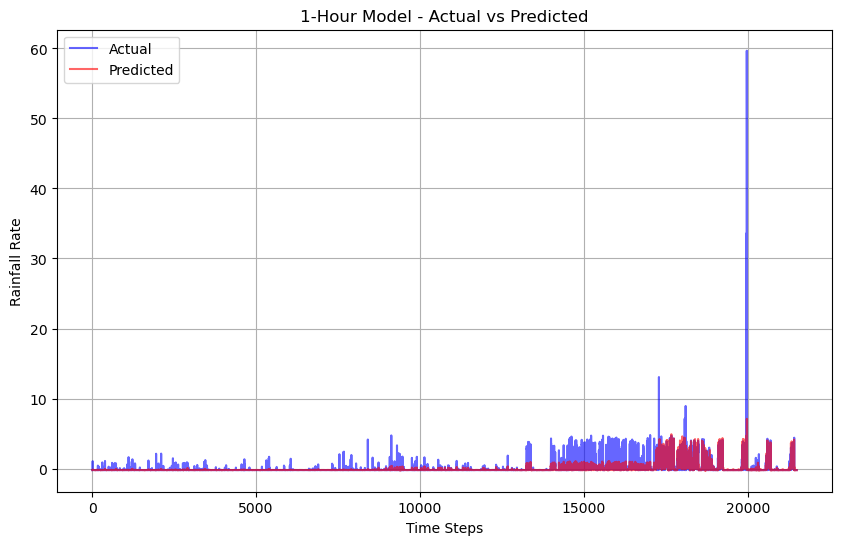

In [7]:
# Train and evaluate model with early stopping and learning rate reduction
def train_and_evaluate(X, y, title):
    input_shape = (X.shape[1], X.shape[2])
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    accuracy_scores = []
    all_predictions = []
    all_actuals = []

    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

    for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = build_lstm_model(input_shape)
        model.fit(
            X_train,
            y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1,
            callbacks=[early_stopping, reduce_lr]
        )

        predictions = model.predict(X_test).flatten()
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        accuracy = (1 - np.mean(np.abs((y_test - predictions) / y_test))) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        all_predictions.extend(predictions)
        all_actuals.extend(y_test)

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"{title} Metrics:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  R²: {avg_r2:.4f}")
    print(f"  Accuracy: {avg_accuracy:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(all_actuals, label='Actual', color='blue', alpha=0.6)
    plt.plot(all_predictions, label='Predicted', color='red', alpha=0.6)
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Rainfall Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return model

# Train and evaluate both models
model_15min = train_and_evaluate(X_15min, y_15min, '15-Minute Model')
model_1hr = train_and_evaluate(X_1hr, y_1hr, '1-Hour Model')